In [4]:
import numpy as np 
import pandas as pd 
import os 
import h5py 
import csv 
import datetime as dt
import matplotlib.pyplot as plt
from sklearn import utils

In [5]:
file_loc = 'cleaned.hdf5'
dset = 'MIT'
def get_psus():
    unique_psu = {}
    with h5py.File(file_loc,'r') as f:
        d = f[dset]
        for b in d.keys():
            if 'PSU' in d[b].attrs:
                if d[b].attrs['PSU'] not in unique_psu:
                    unique_psu[d[b].attrs['PSU']] = 1
                else:
                    unique_psu[d[b].attrs['PSU']] = unique_psu[d[b].attrs['PSU']]+1
    return unique_psu
    

<h2><font color = #bf5700>Metadata analysis</font></h2>

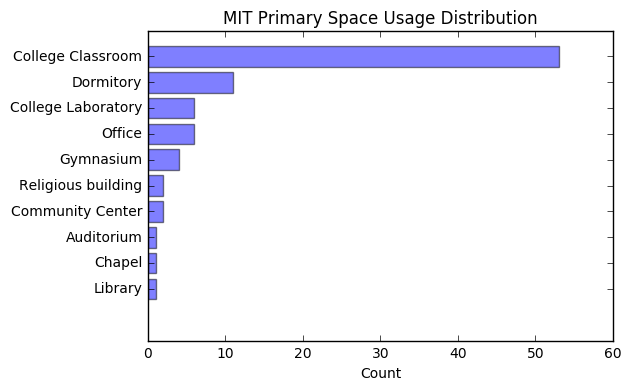

In [17]:
data = get_psus()
uniques = data.keys()
values = [data[psu] for psu in uniques]
df = pd.DataFrame()
df.loc[:,'PSU'] = uniques
df.loc[:,'Count'] = values
df.sort_values(by='Count',ascending=True,inplace=True)
plt.barh(np.arange(len(uniques)), df.loc[:,'Count'], align='center', alpha=0.5)
plt.yticks(np.arange(len(uniques)), df.loc[:,'PSU'])
plt.xlabel('Count')
plt.title('MIT Primary Space Usage Distribution')
plt.show()

<h2><font color=#bf5700>Daily Profile</font></h2>

In [24]:
def byte_to_obj(build_df):
    df = build_df.copy()
    #Byte to String (decode utf8) to Datetime (parsetime with format YYYY-mm-dd HH:MM:SS)
    df.loc[:,0] = df.apply(lambda x:dt.datetime.strptime(x[0].decode('utf8'),'%Y-%m-%d %H:%M:%S'),axis=1 )
    #Byte to String (decode utf8) to float
    df.loc[:,1] = df.apply(lambda x: float(x[1].decode('utf8')),axis=1)
    return df
#Clean zero values
def clean_zero(build_df):
    df = build_df.copy()
    #Return times and data where usage is positive.
    #Filters zero and negative numbers
    return df[df[1]>0]

def daily_profile(building, year):
    with h5py.File(file_loc,'r') as f:
        df = pd.DataFrame(f['{}/{}/{}'.format(dset,building,year)][()])
        df = clean_zero(byte_to_obj(df))
        data = []
        for h in range(24):
            hour_data = df[df.apply(lambda x: x[0].hour==h,axis=1)].loc[:,1]
            data.append(hour_data)
    return data

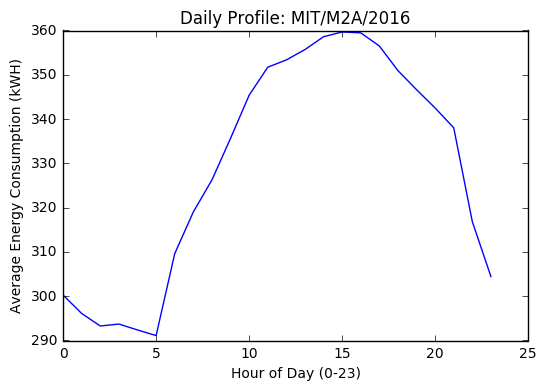

In [25]:
prof = daily_profile('M2A',2016)
hour_avs = [sum(d)/len(d) for d in prof]
plt.plot(np.arange(24),hour_avs)
plt.xlabel('Hour of Day (0-23)')
plt.ylabel('Average Energy Consumption (kWH)')
plt.title('Daily Profile: MIT/M2A/2016')
plt.show()

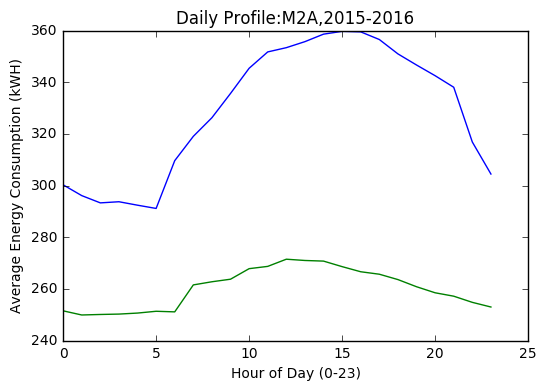

In [26]:
prof_2015 = daily_profile('M2A',2015)
hour_avs_2015 = [sum(d)/len(d) for d in prof_2015]
plt.plot(np.arange(24),hour_avs)
plt.plot(np.arange(24),hour_avs_2015)
plt.xlabel('Hour of Day (0-23)')
plt.ylabel('Average Energy Consumption (kWH)')
plt.title('Daily Profile:M2A,2015-2016')
plt.show()

In order to compare we need to <b>normalize</b> data

<h2><font color=#bf5700>Normalization techniques</font></h2>
<h3><font color=#333f48>Z-score normalization </font></h3>

In [27]:
def z_normalize(avs,nested_data=False):
    #If data is direct output from profile, it is in form [[a1,a2,a3,a4,...],[b1,b2,b3,b4,...],...]
    if(nested_data):
        arr = [np.array(h_data) for h_data in avs]
        mus = [np.mean(h_data) for h_data in avs]
        mu = np.mean(mus)
        std = np.std(mus)
        return np.array([(r - mu)/std for r in arr])
    else:
        mu = np.mean(avs)
        std = np.std(avs)
        return (np.array(avs)-mu)/std

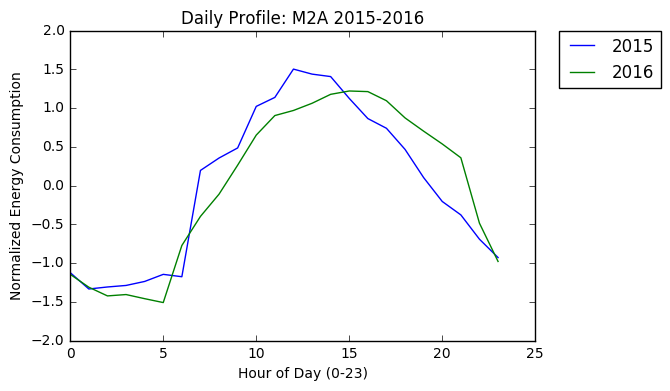

In [28]:
plt.plot(np.arange(24),z_normalize(hour_avs_2015),label='2015')
plt.plot(np.arange(24),z_normalize(hour_avs),label='2016')
plt.xlabel('Hour of Day (0-23)')
plt.ylabel('Normalized Energy Consumption')
plt.title('Daily Profile: M2A 2015-2016')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

<h2> <font color = #bf5700> Profile Comparison </font> </h2>

We can see that buildings with the same primary space usage tend to have the same daily profile shape. Shown below are the daily profiles of two dormitory buildings (M2A, M9A)

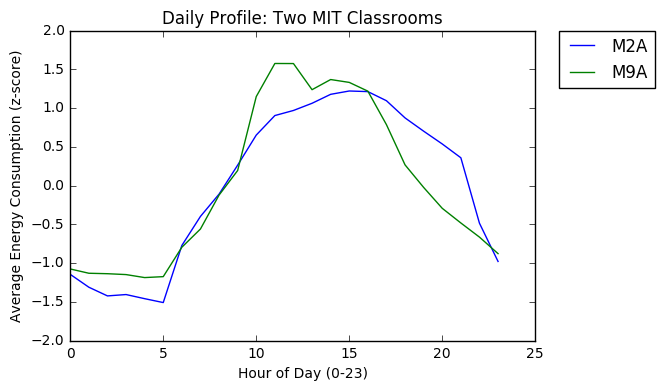

In [31]:
M2A_avs = [sum(d)/len(d) for d in daily_profile('M2A',2016)]
M9A_avs = [sum(d)/len(d) for d in daily_profile('M9A',2016)]
plt.plot(np.arange(24),z_normalize(M2A_avs),label='M2A')
plt.plot(np.arange(24),z_normalize(M9A_avs),label='M9A')
plt.xlabel('Hour of Day (0-23)')
plt.ylabel('Average Energy Consumption (z-score)')
plt.title('Daily Profile: Two MIT Classrooms')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

<h2><font color = #bf5700> Temporal Data Analysis</font> </h2> 
<h3> Entire Building Data</h3>
Plot the data for the building through all years

In [ ]:
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context(font_scale=1.5)
sns.set_color_codes("pastel")

In [34]:
def plot_psu(psu): 
    with h5py.File(file_loc,'r') as f: 
        ds = f[dset]
        psu_builds = [ds[building] for building in ds.keys() if 'PSU' in ds[building].attrs.keys()]
        subset = [building for building in psu_builds if building.attrs['PSU']==psu]
        length = len(subset)
        plotsize = 1.5
        for build in subset:
            years = build.keys()
            frames = [pd.DataFrame(build[year][()]) for year in years]
            combined = pd.concat(frames)
            df = byte_to_obj(combined).reset_index(drop = True)
            df.loc[:,1].plot(subplots=True,figsize=(15,plotsize))
            plt.tight_layout()
            plt.title(build.name)
            plt.show()

<h4>College Classroom </h4>

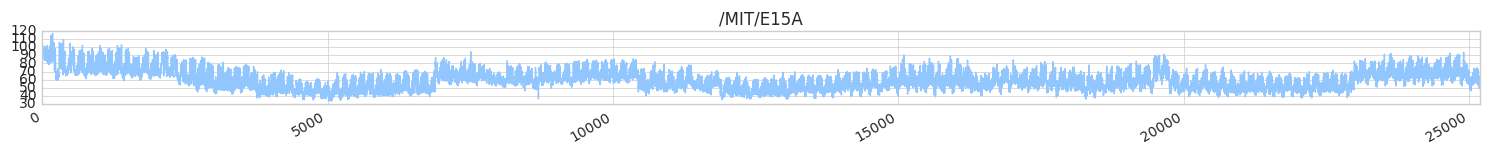

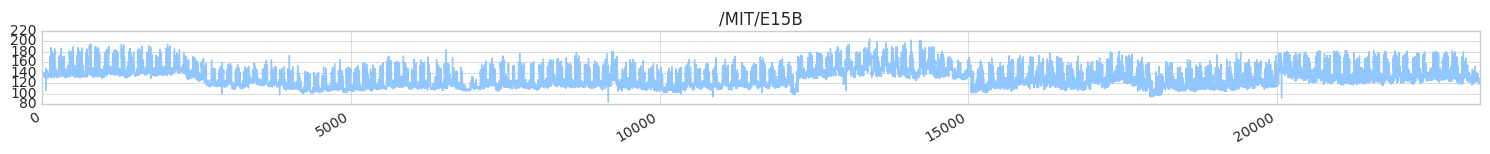

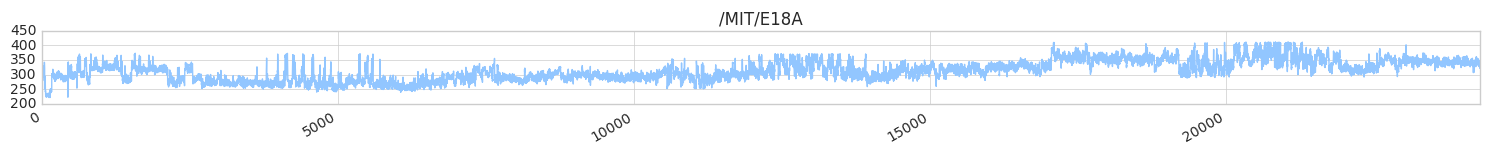

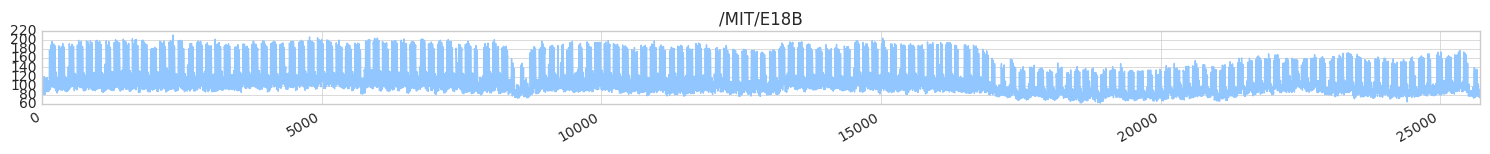

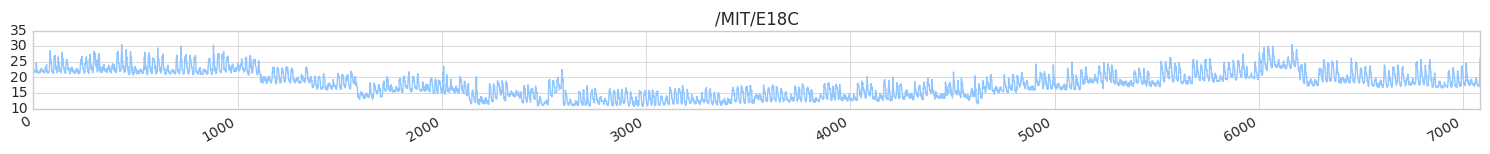

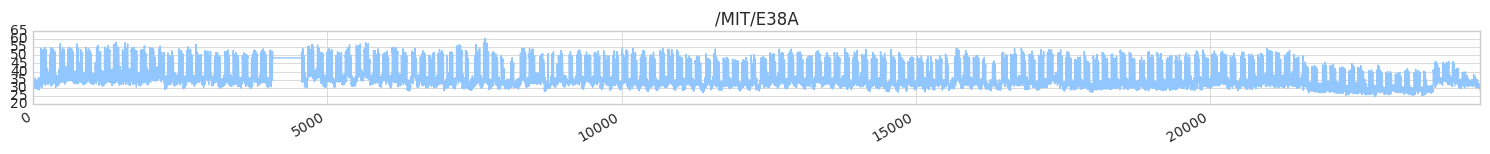

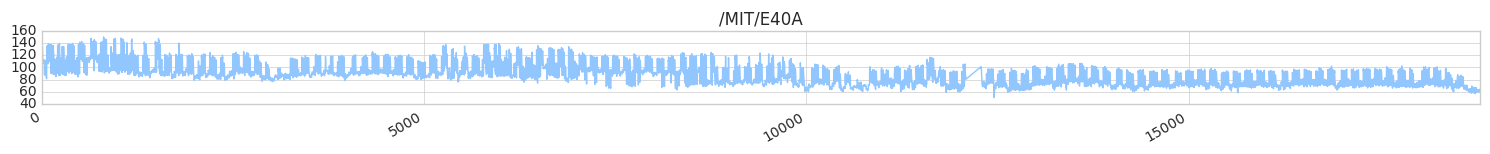

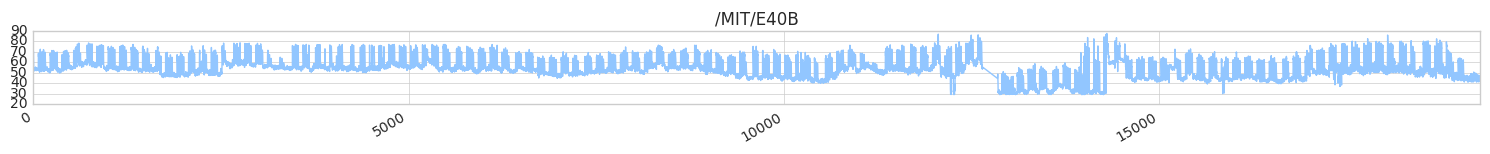

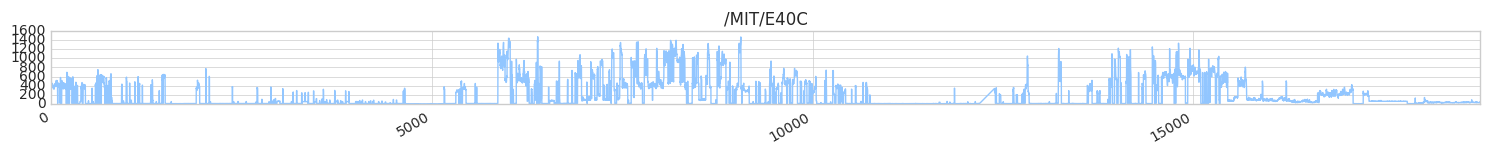

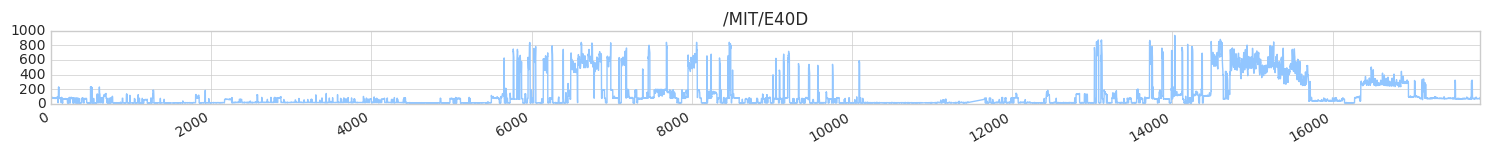

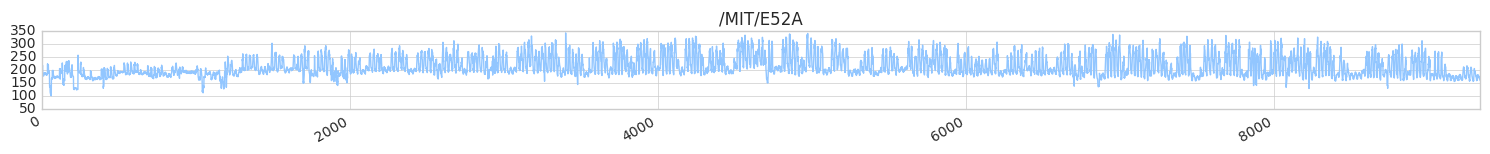

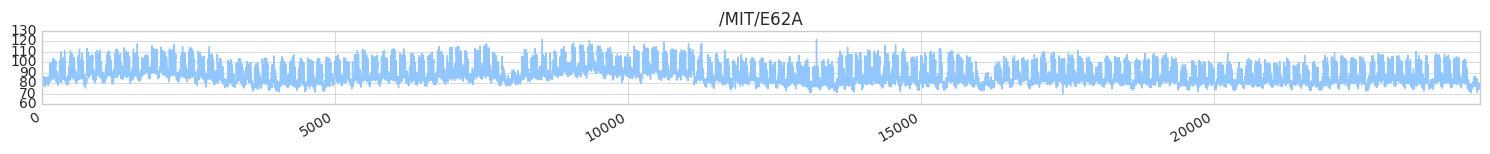

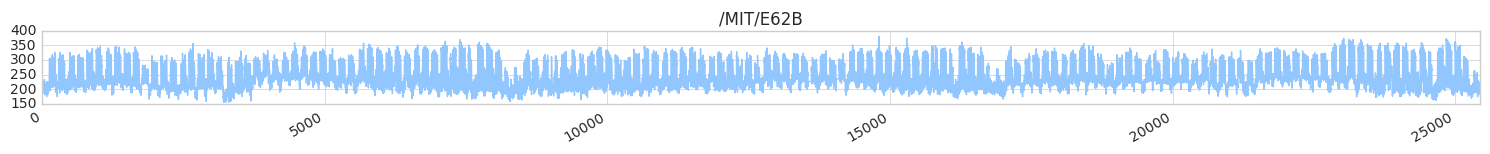

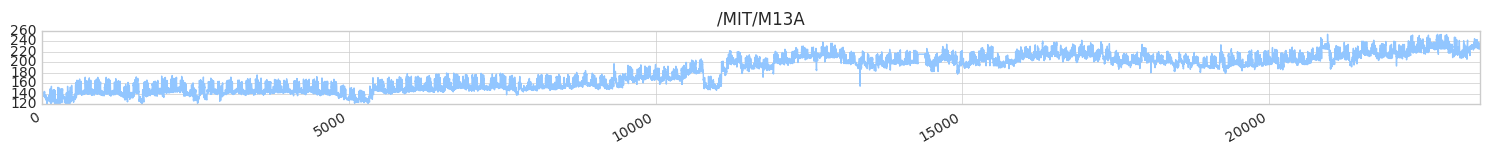

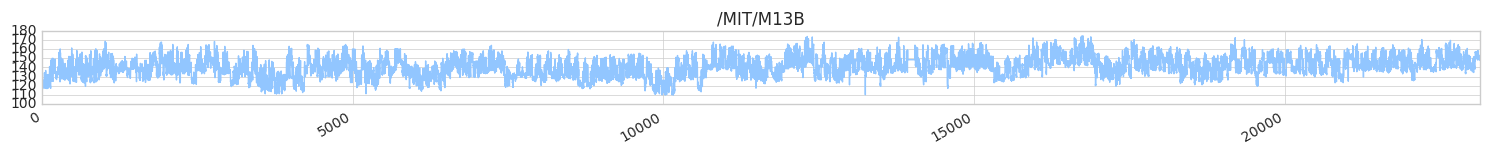

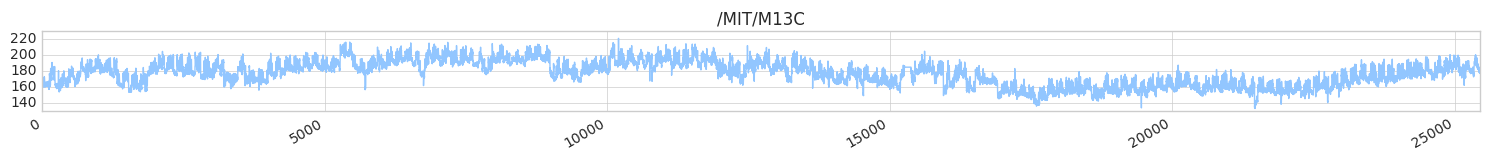

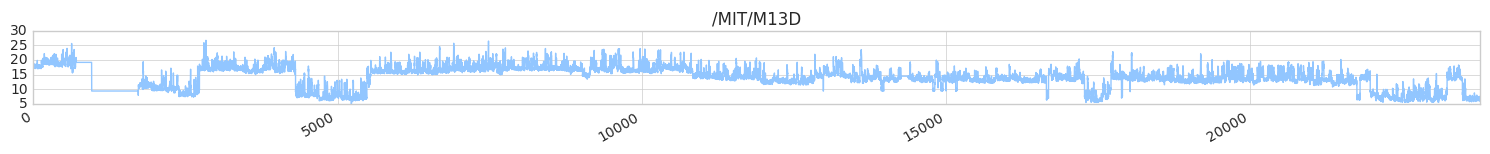

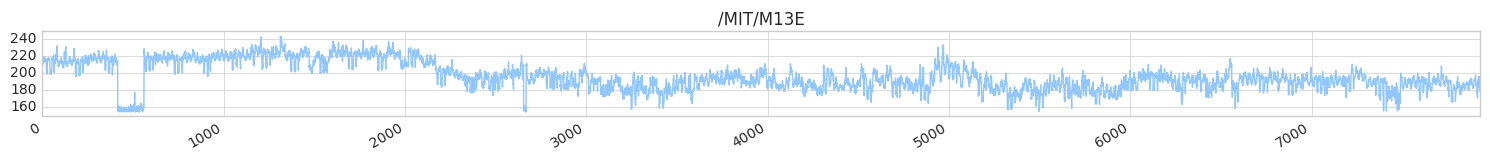

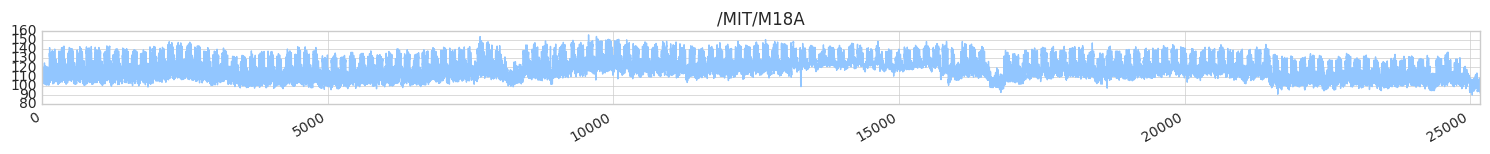

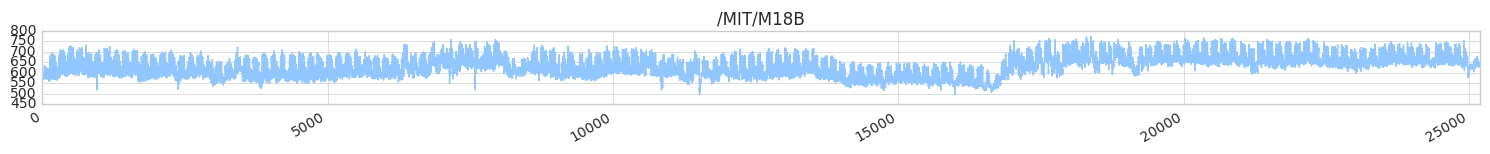

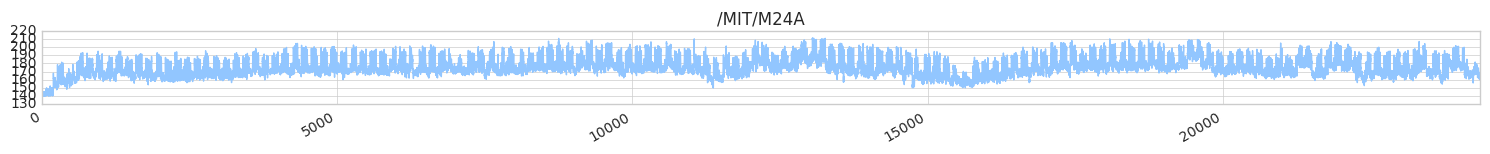

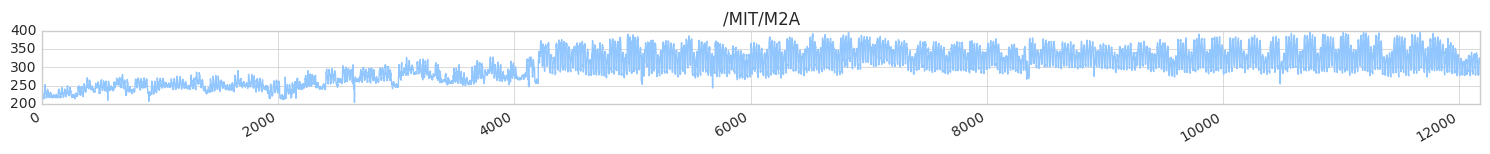

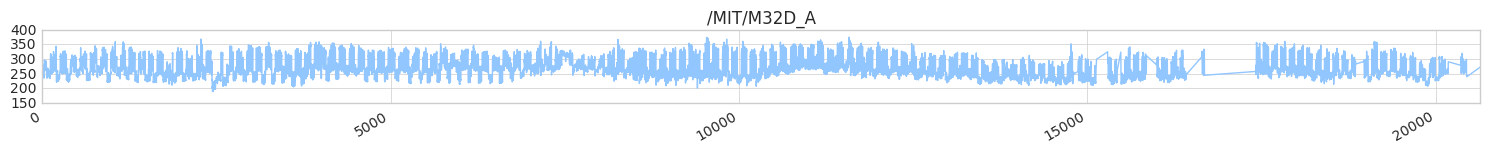

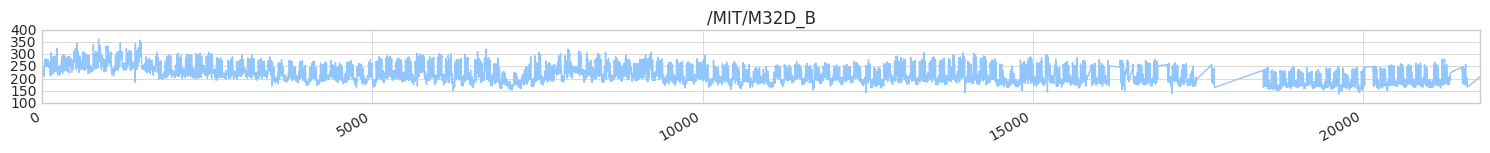

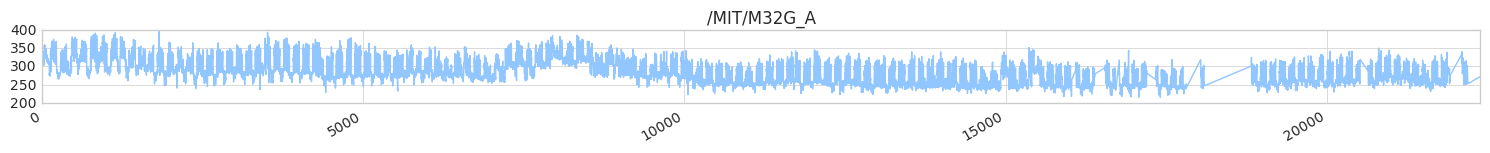

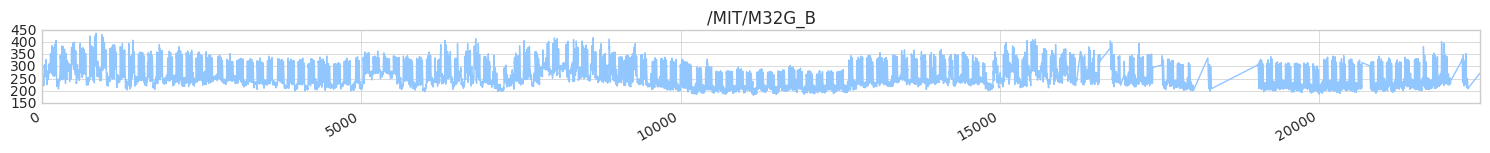

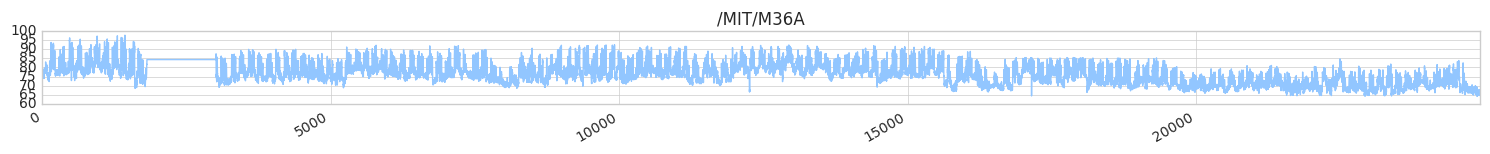

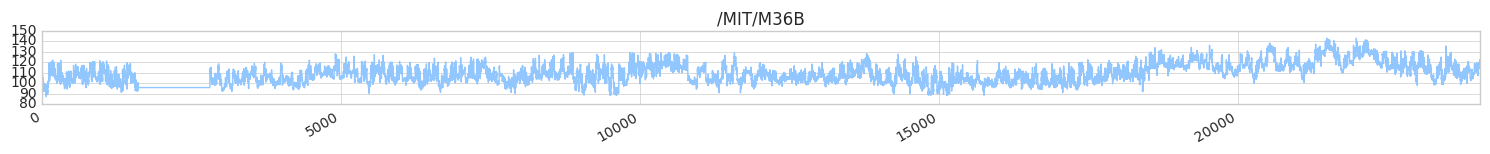

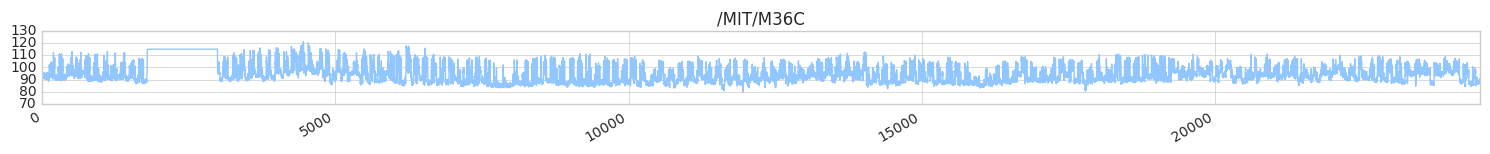

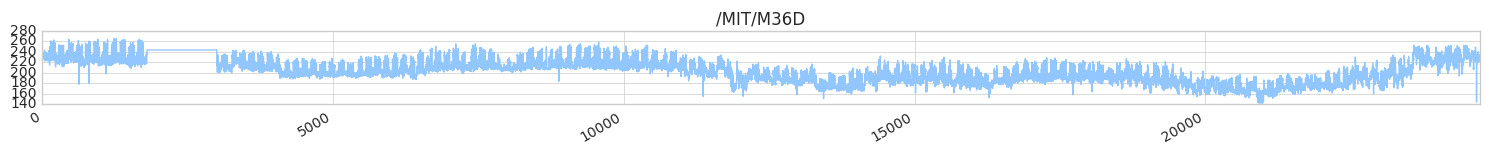

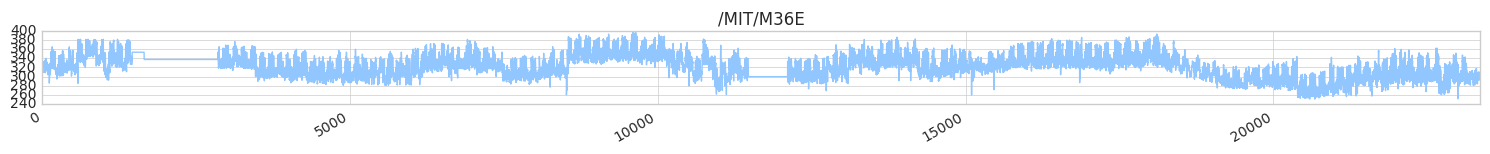

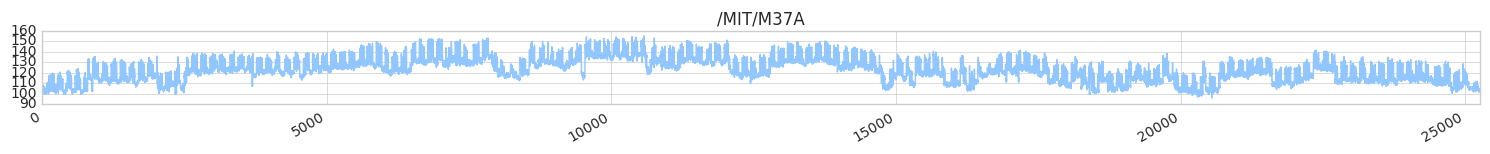

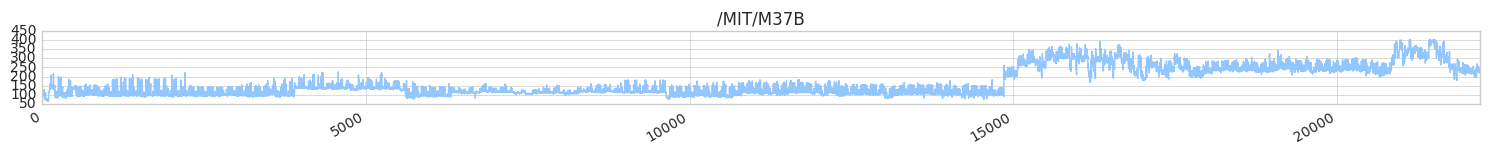

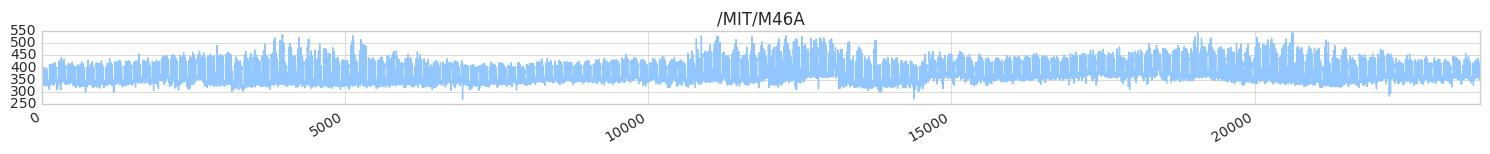

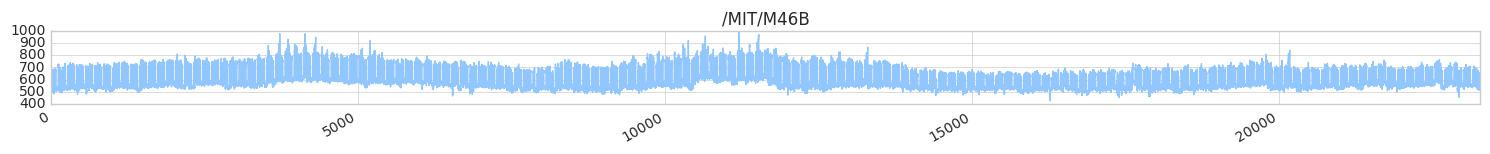

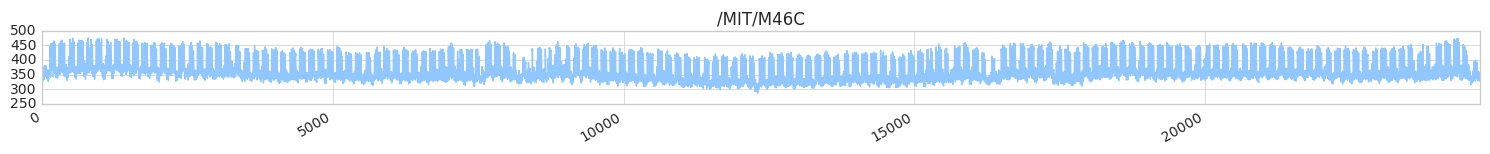

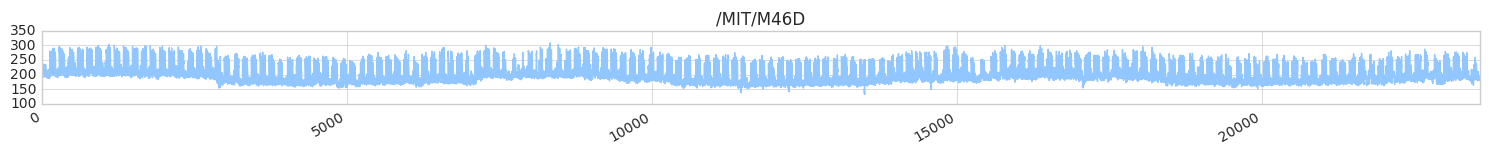

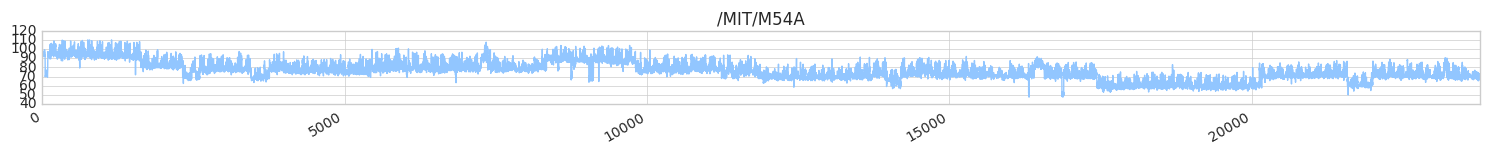

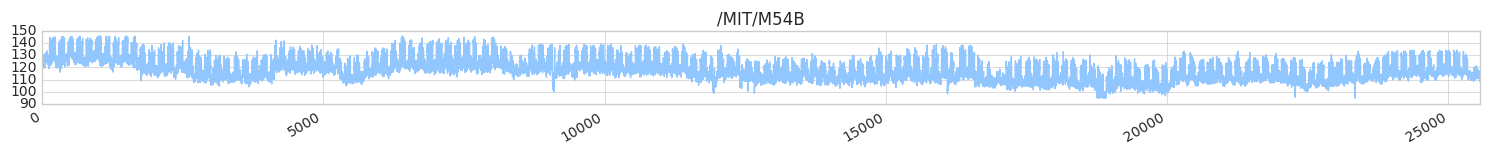

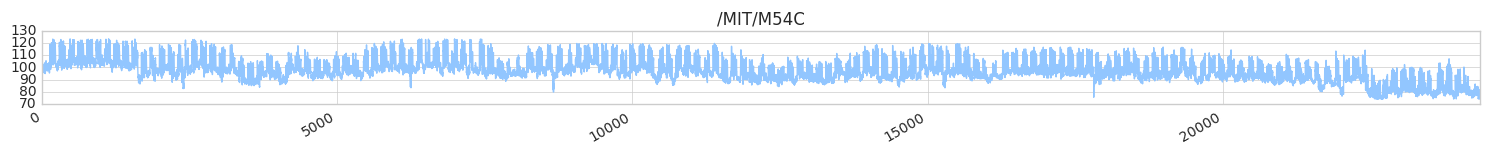

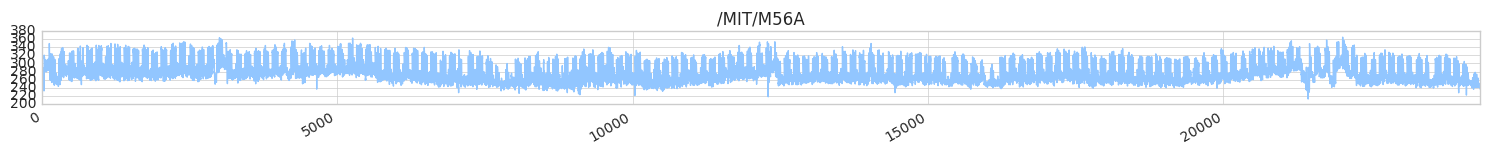

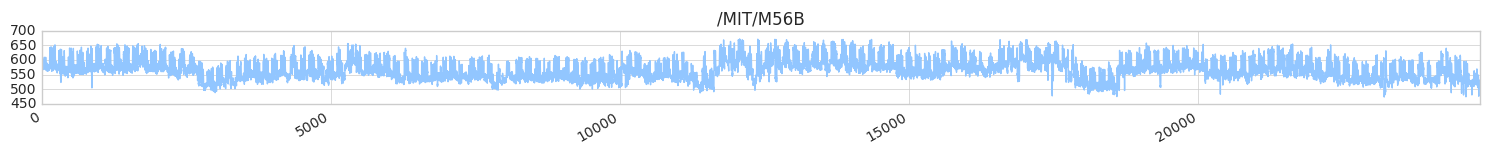

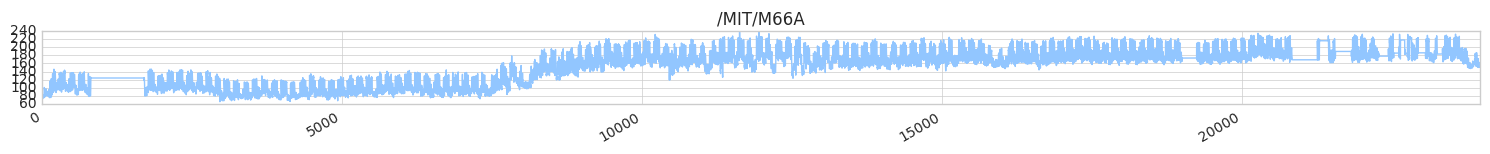

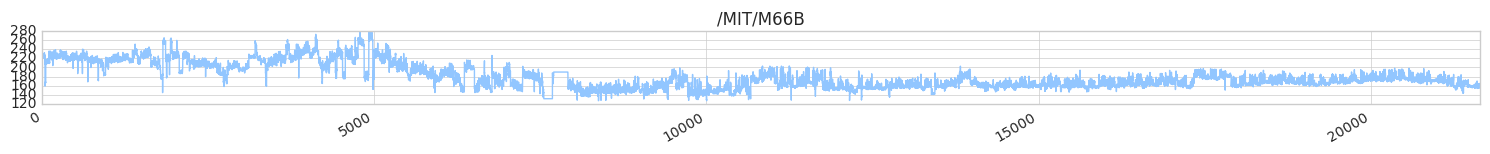

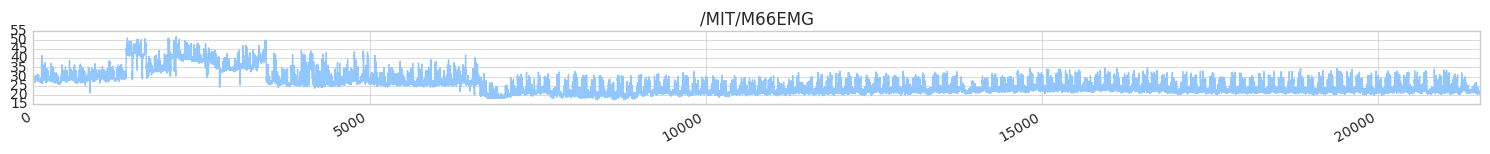

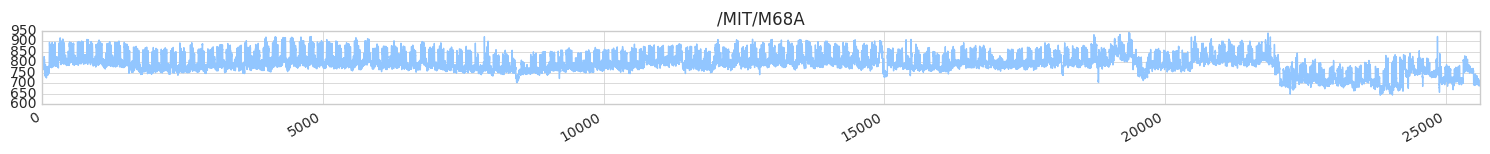

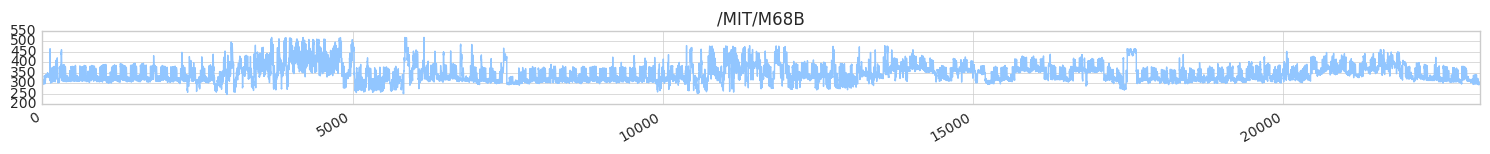

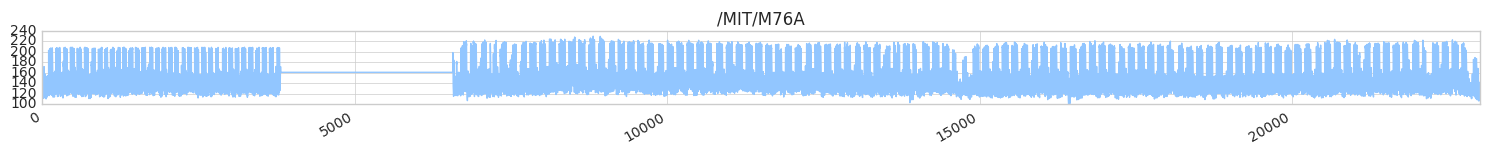

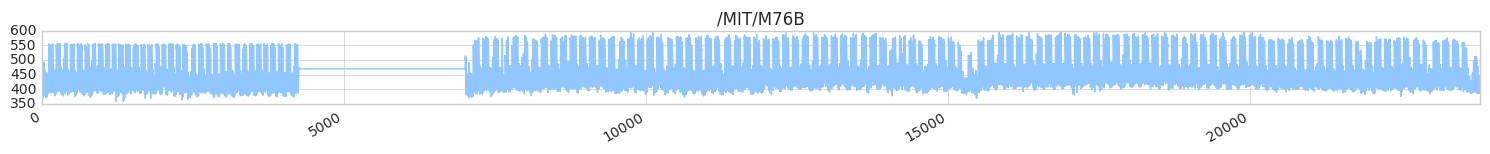

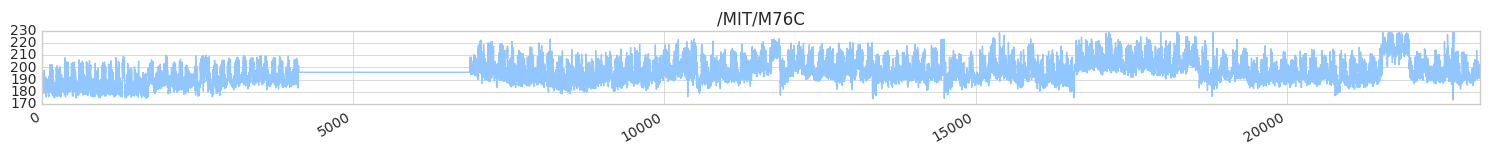

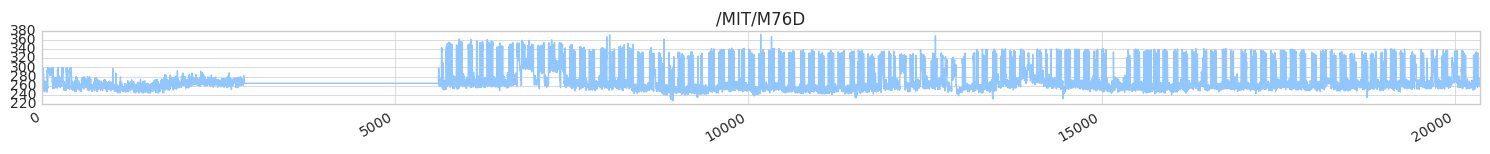

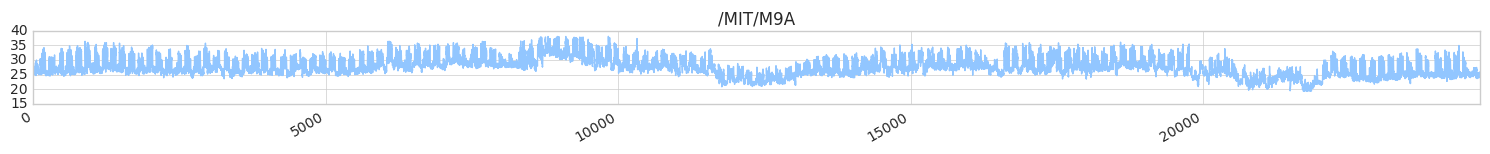

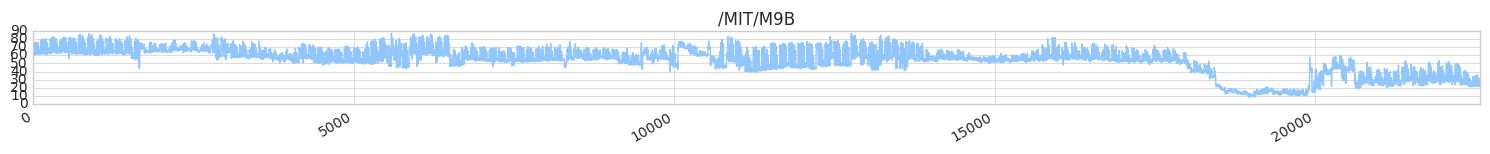

In [38]:
plot_psu('College Classroom')

<h4>Dormitory</h4>

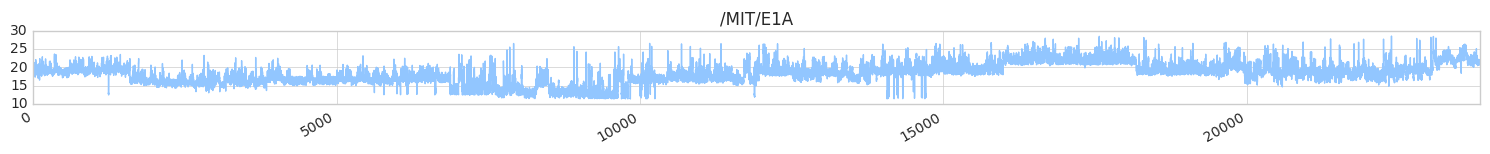

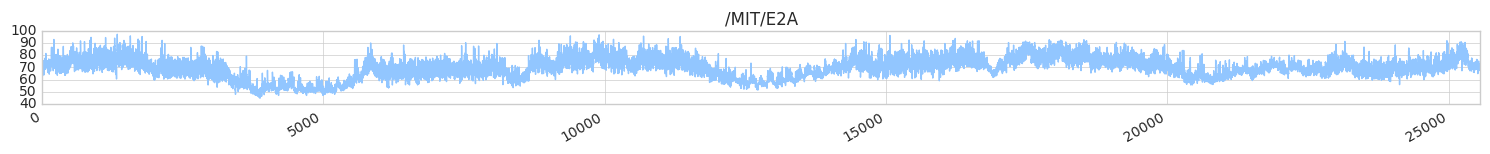

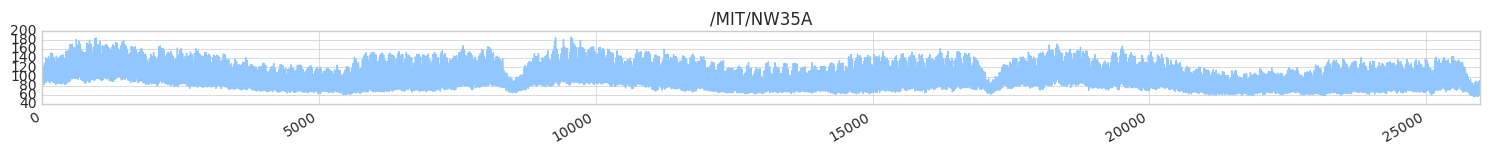

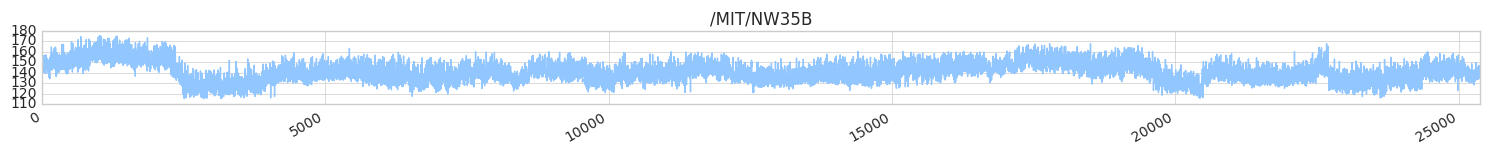

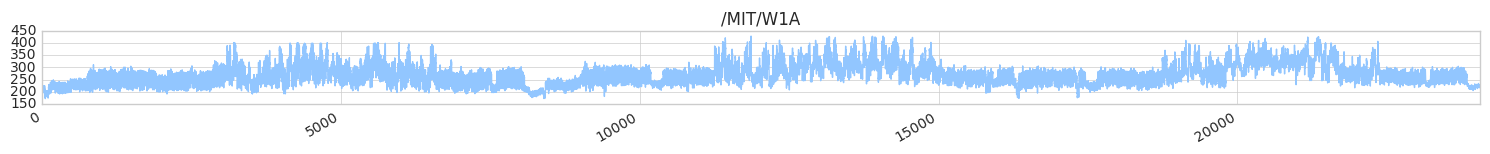

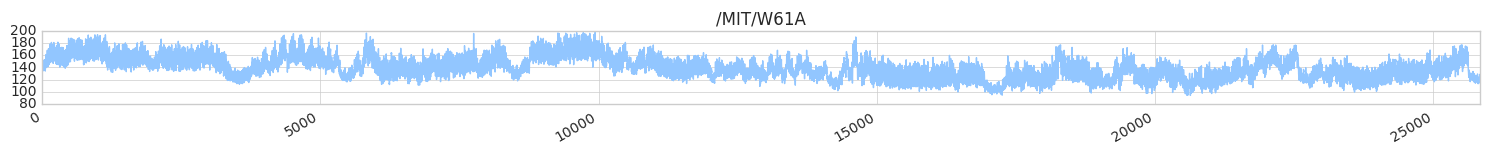

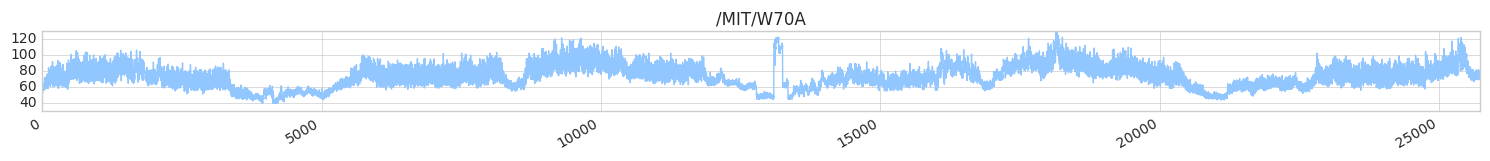

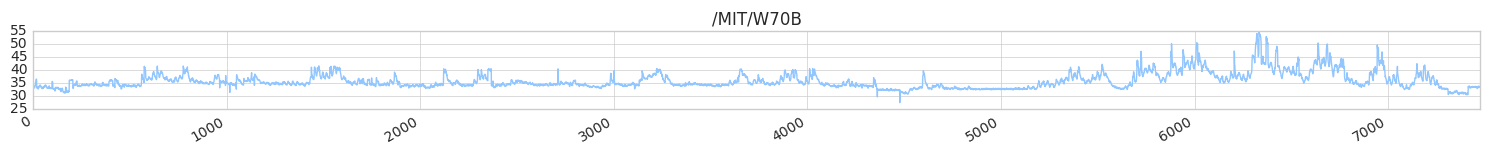

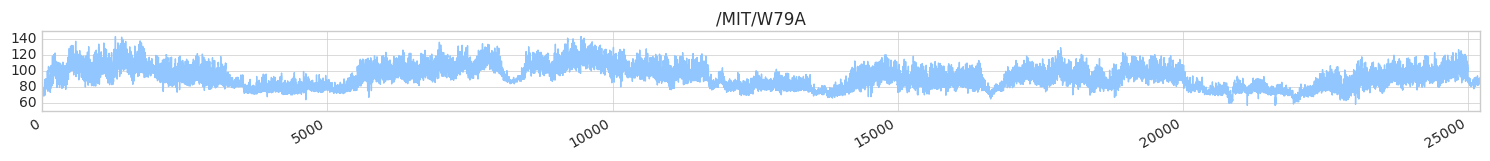

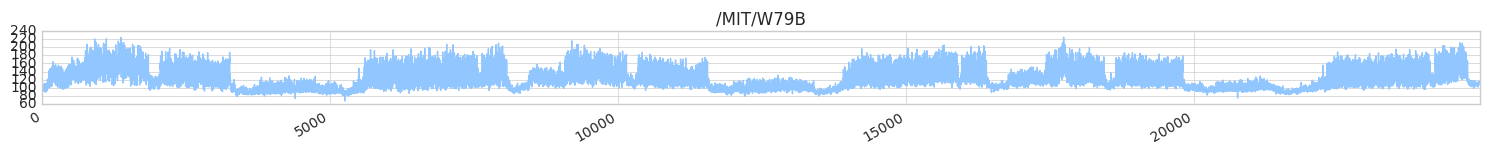

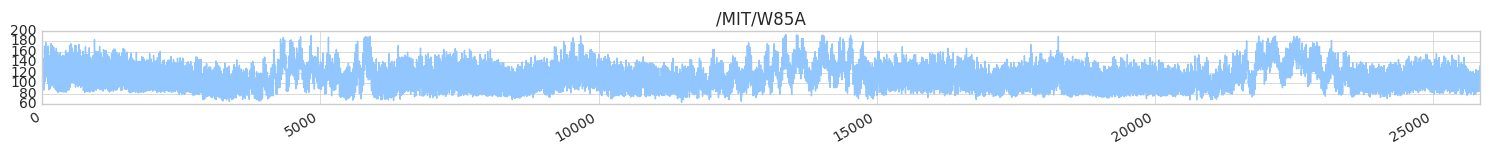

In [42]:
plot_psu('Dormitory')

<h4>College Laboratory</h4>

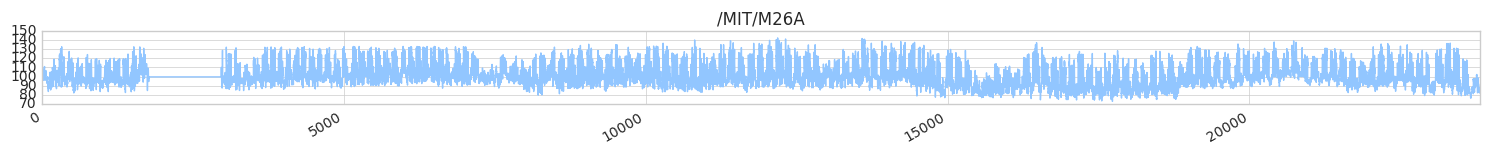

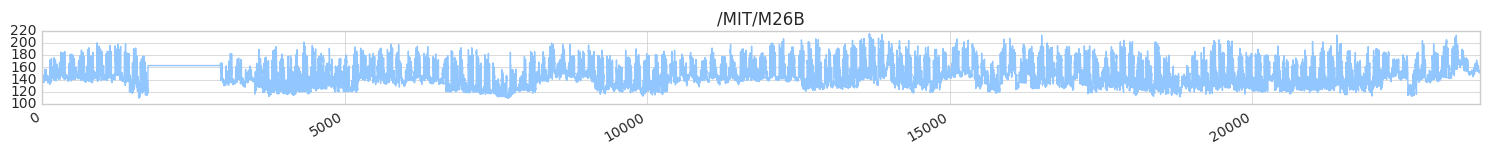

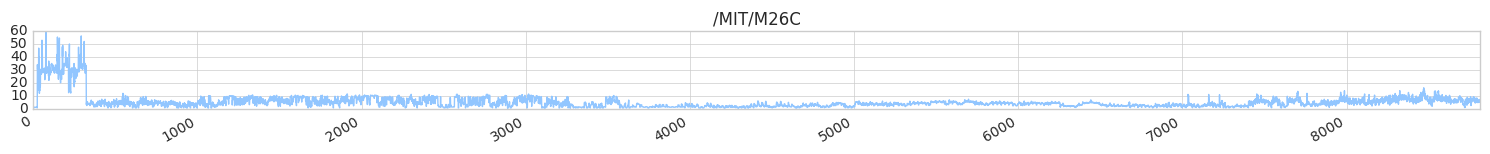

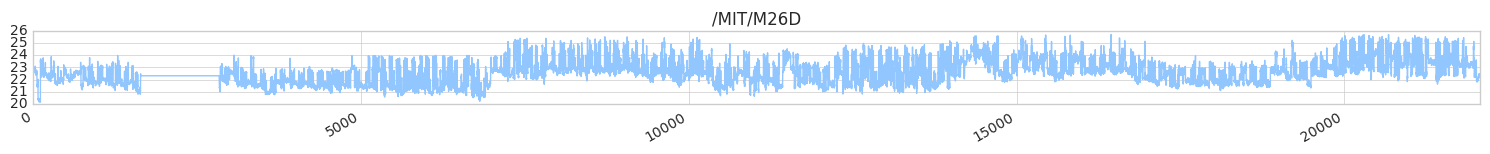

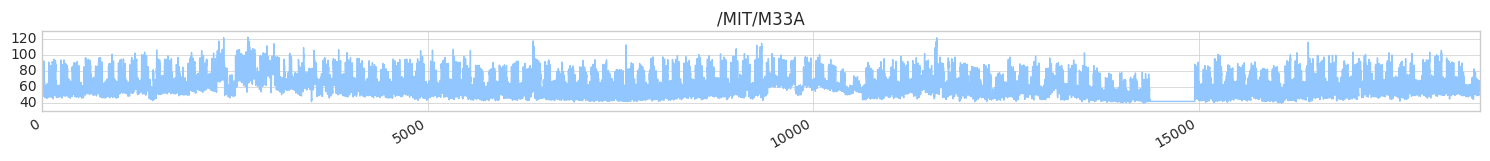

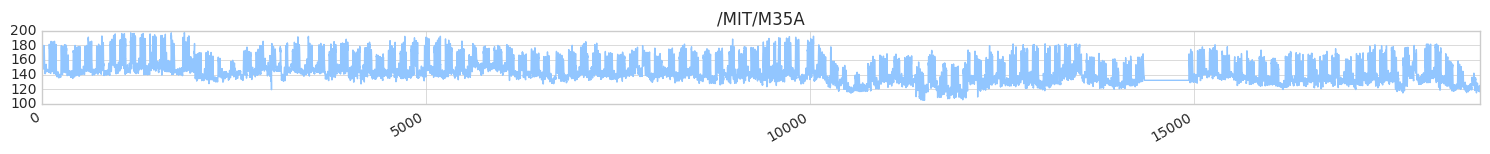

In [43]:
plot_psu('College Laboratory')

<h4>Office</h4>

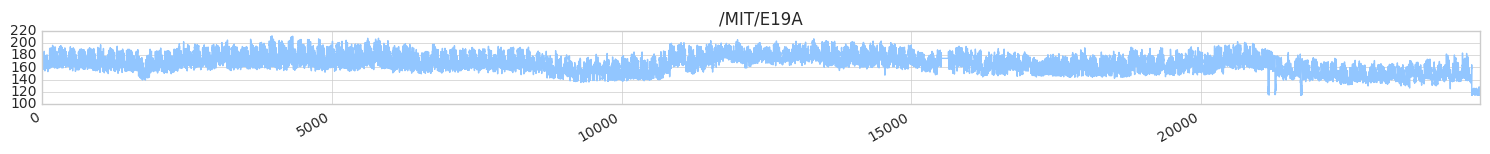

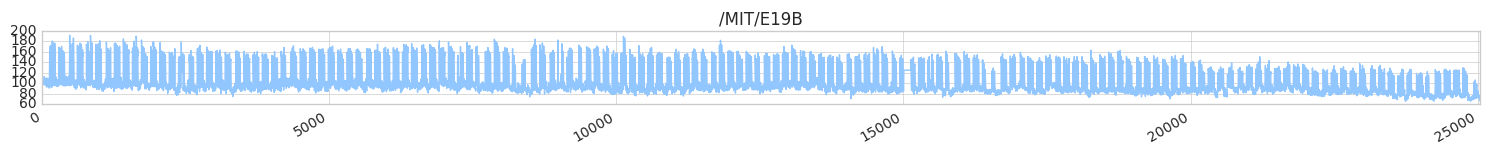

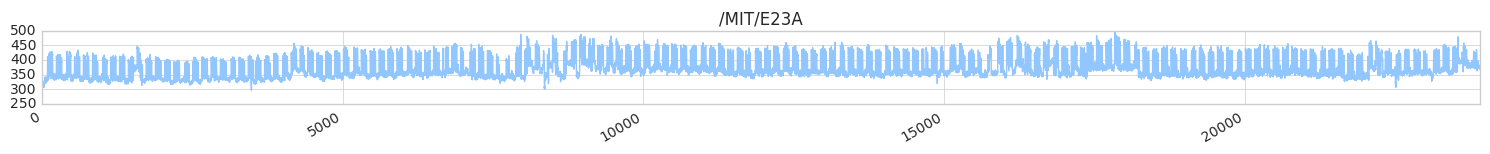

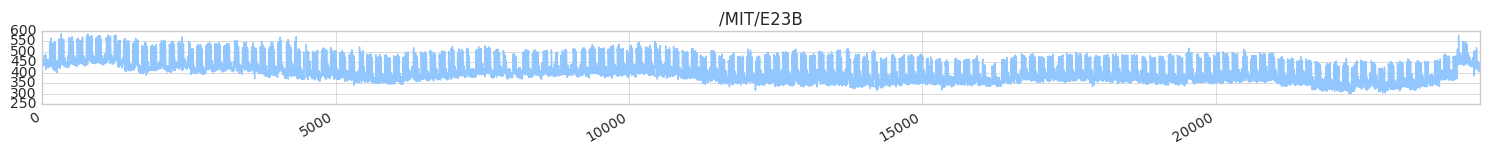

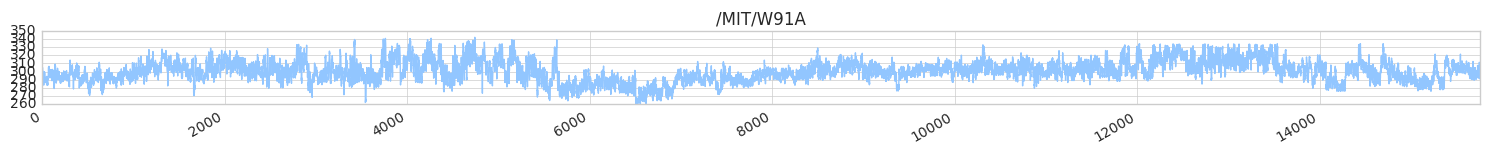

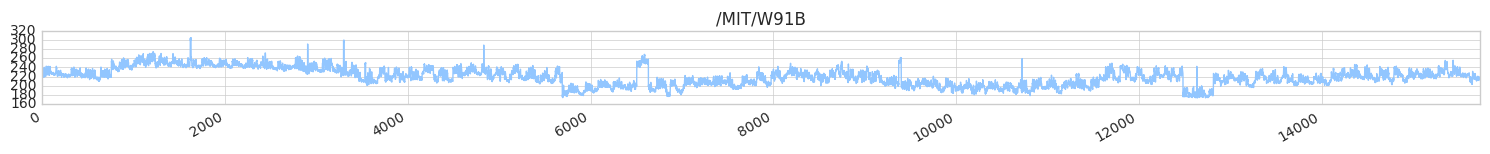

In [44]:
plot_psu('Office')

<h4>Gymnasium</h4>

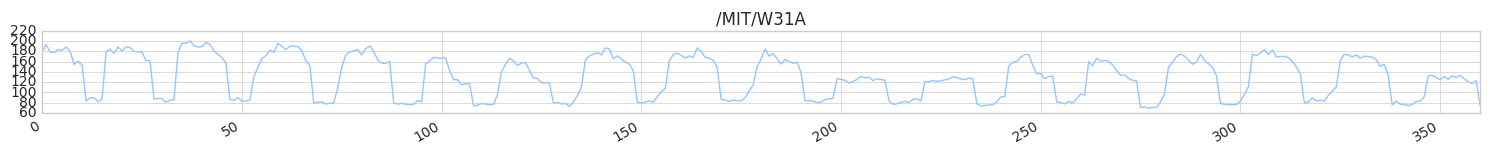

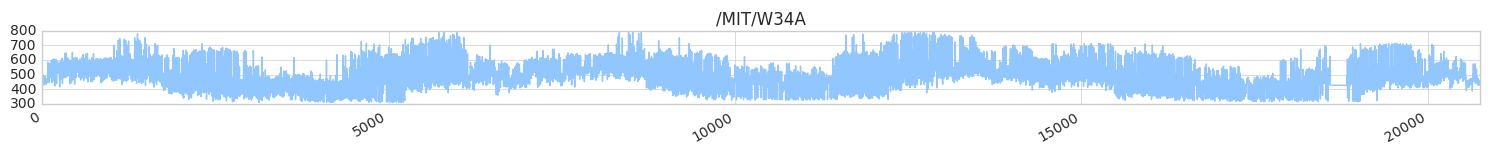

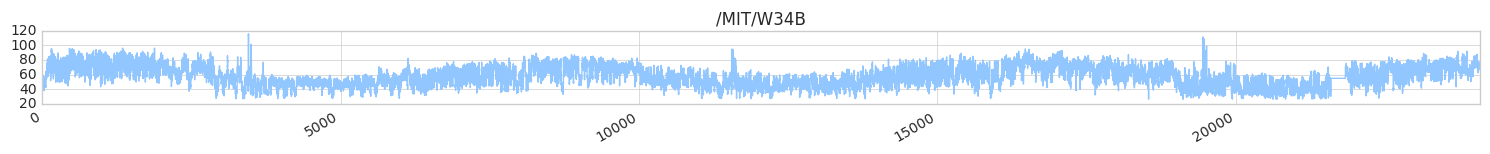

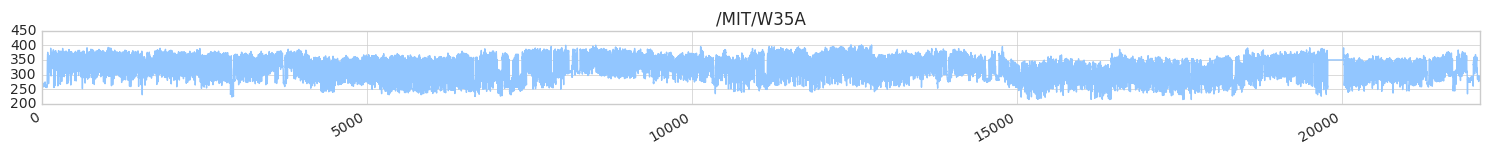

In [45]:
plot_psu('Gymnasium')

<h4>Community Center</h4>

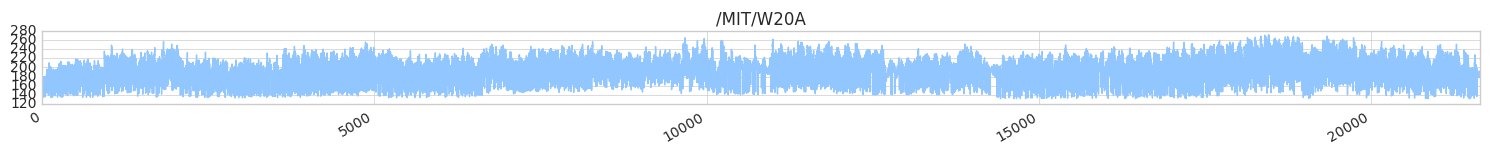

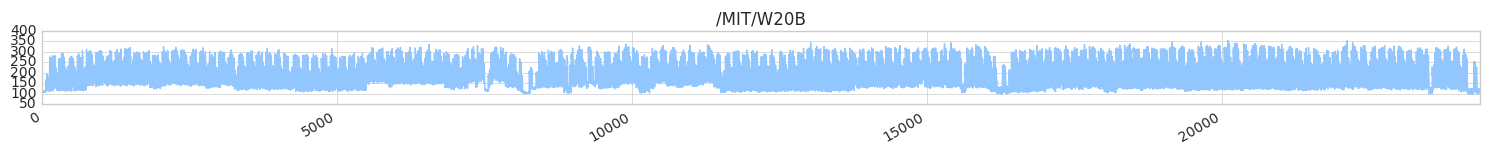

In [47]:
plot_psu('Community Center')

<h4>Religious building</h4>

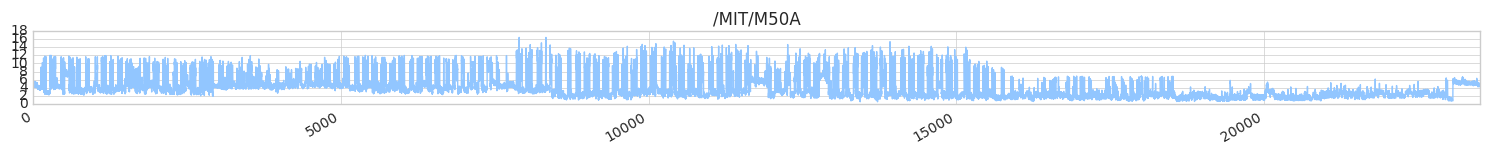

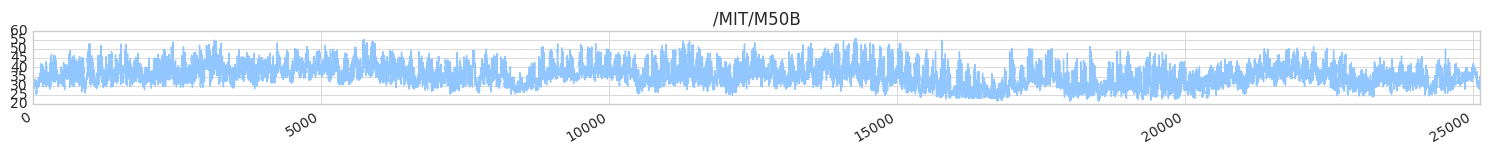

In [50]:
plot_psu('Religious building')

<h4>Auditorium </h4>


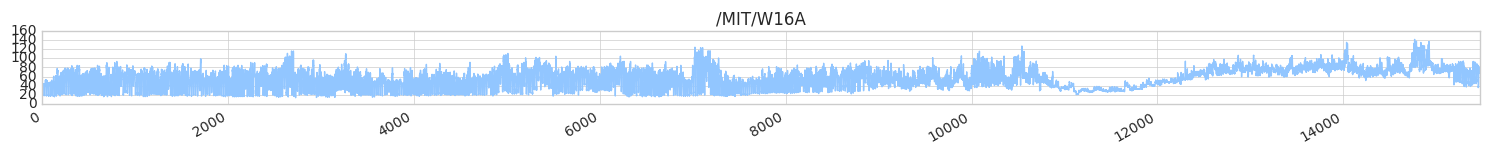

In [53]:
plot_psu('Auditorium')

<h4>Chapel </h4>

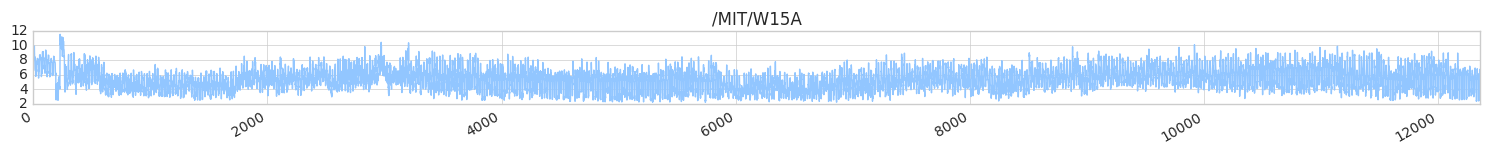

In [54]:
plot_psu('Chapel')